In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [7]:
def plot_gaussian_contour(mean, cov, ax=None):
    """
    Dibujar el contorno de una derivación estándar en una distribución gaussiana 2D.

    Entrada:
    mean : array-like, shape (2,)
        La media de la distribución gaussiana.
    cov : array-like, shape (2, 2)
        Matriz de covarianza de la distribución gaussiana.
    ax : matplotlib.axes.Axes, optional
        Los ejes en que pintar el dibujo. Si None, se crea una nueva figura.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Calcular autovalores y autovectores con eigh (optimizado para matrices simétricas)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Ángulo de rotación.
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))

    # Ancho y alto de las dos desviación estándar (se corresponden con los autovalores).
    width, height = 2 * np.sqrt(eigenvalues)

    # Dibujar elipse.
    ellipse = Ellipse(xy=mean, width=width, height=height,
                      angle=angle, fill=False, color='blue')
    ax.add_artist(ellipse)

    return ax

#### Modificar orden de salida de los datos

In [8]:
import numpy as np

def EMGaussianMixture(data, num_components, parameters):
    """
    EMGaussianMixture: Implementación del algoritmo EM para entrenar una mezcla de gaussianas.
    [prior_probs, means, covariances, likelihood, posterior_probs] = EMGaussianMixture(data, num_components, parameters)

    Entradas:
    data : Matriz con las muestras (cada columna representa un punto de datos)
    num_components : Número de componentes gaussianos en la mezcla
    parameters : Diccionario con configuraciones adicionales:
                 - parameters.max_iterations: Número máximo de iteraciones
                 - parameters.initialize_means: Si es False, inicializa las medias usando random. Si es True, inicializa las medias usando los datos

    Salidas:
    prior_probs : Probabilidades a priori de los componentes
    means : Medias de las gaussianas
    covariances : Matrices de covarianza de los componentes gaussianos
    likelihood : Log-verosimilitud de los datos
    posterior_probs : Probabilidades a posteriori de cada componente para los datos
    """
    rng = np.random.default_rng()  # Generador de números aleatorios
    dim, num_samples = v.shape[0], v.shape[1]  # Dimensión de los datos y número de muestras
    epsilon = 1e-7  # Evitar problemas de singularidad
    
    # Inicialización de parámetros
    if not parameters['initialize_means']:
        covariances = np.array([np.eye(dim) for f in range(num_components)]) # Inicialización de las covarianzas como matrices identidad
        means = rng.random((dim, num_components)) * np.max(data, axis=1, keepdims=True) # Generar aleatoriamente las medias iniciales
        prior_probs = rng.random(num_components) # Generar aleatoriamente las probabilidades a priori
        prior_probs = prior_probs / prior_probs.sum()  # Normalizar las probabilidades
        
    else:
        # Inicialización de las covarianzas como matrices de covarianza de los datos
        covariances = np.array([
            np.cov(data) + np.eye(dim) * epsilon for h in range(num_components)
        ])
        means = data[:, :num_components] # Usar las primeras columnas de los datos como medias iniciales
        prior_probs = np.ones(num_components) / num_components # Inicialización uniforme de las probabilidades a priori

    posterior_probs = np.zeros((num_components, num_samples)) # Matriz para almacenar las probabilidades a posteriori
    likelihood = np.zeros(parameters['max_iterations']) # Historial de verosimilitud

    for iteration in range(parameters['max_iterations']):
        # Inicializar matriz log-posterior
        log_posterior_probs = np.zeros((num_components, num_samples))
        
        # Paso E(Calcular las probabilidades a posteriori)
        for j in range(num_components):
            diff = data - means[:, j:j+1]# Calcular la diferencia entre los datos y las medias actuales para el componente j
            inv_covariance = np.linalg.inv(covariances[j]) # Inversa de la matriz de covarianza del componente j
            log_det_covariance = np.linalg.slogdet(covariances[j])[1] # Determinante logarítmico de la matriz de covarianza para estabilidad numérica
            
            # Calcular la densidad de la distribución gaussiana en escala logarítmica
            log_gaussian = -0.5 * (
                np.sum(diff.T @ inv_covariance * diff.T, axis=1)
                + dim * np.log(np.pi * 2)
                + log_det_covariance    
            )
            # Incorporar las probabilidades a priori en escala logarítmica
            log_posterior_probs[j, :] = np.log(prior_probs[j]) + log_gaussian

        # Normalización en escala logarítmica
        log_posterior_probs = log_posterior_probs - np.logsumexp(log_posterior_probs, axis=0)
        posterior_probs = np.exp(log_posterior_probs) # Convertir de logaritmo a escala lineal

        # Paso M: Actualizar los parámetros del modelo
        total_posterior = posterior_probs.sum(axis=1) # Sumar responsabilidades para cada componente
        prior_probs = total_posterior / num_samples # Actualizar las probabilidades a priori
        means = (data @ posterior_probs.T) / total_posterior # Actualizar las medias ponderadas por las responsabilidades
        
        covariances = np.zeros((num_components, dim, dim))
        
        for j in range(num_components):
            diff = data - means[:, j:j+1]# Diferencia entre datos y nueva media
            
            covariances[j] = (
                (posterior_probs[j, :] * diff) @ diff.T / total_posterior[j] # Covarianza ponderada
                + np.eye(dim) * epsilon # Regularización para evitar singularidad
            )

        # Calcula la verosimilitud logarítmica del modelo
        log_likelihood = np.sum(np.logsumexp(log_posterior_probs, axis=0))
        likelihood[iteration] = log_likelihood # Registrar la verosimilitud

    return prior_probs, means, covariances, likelihood, posterior_probs


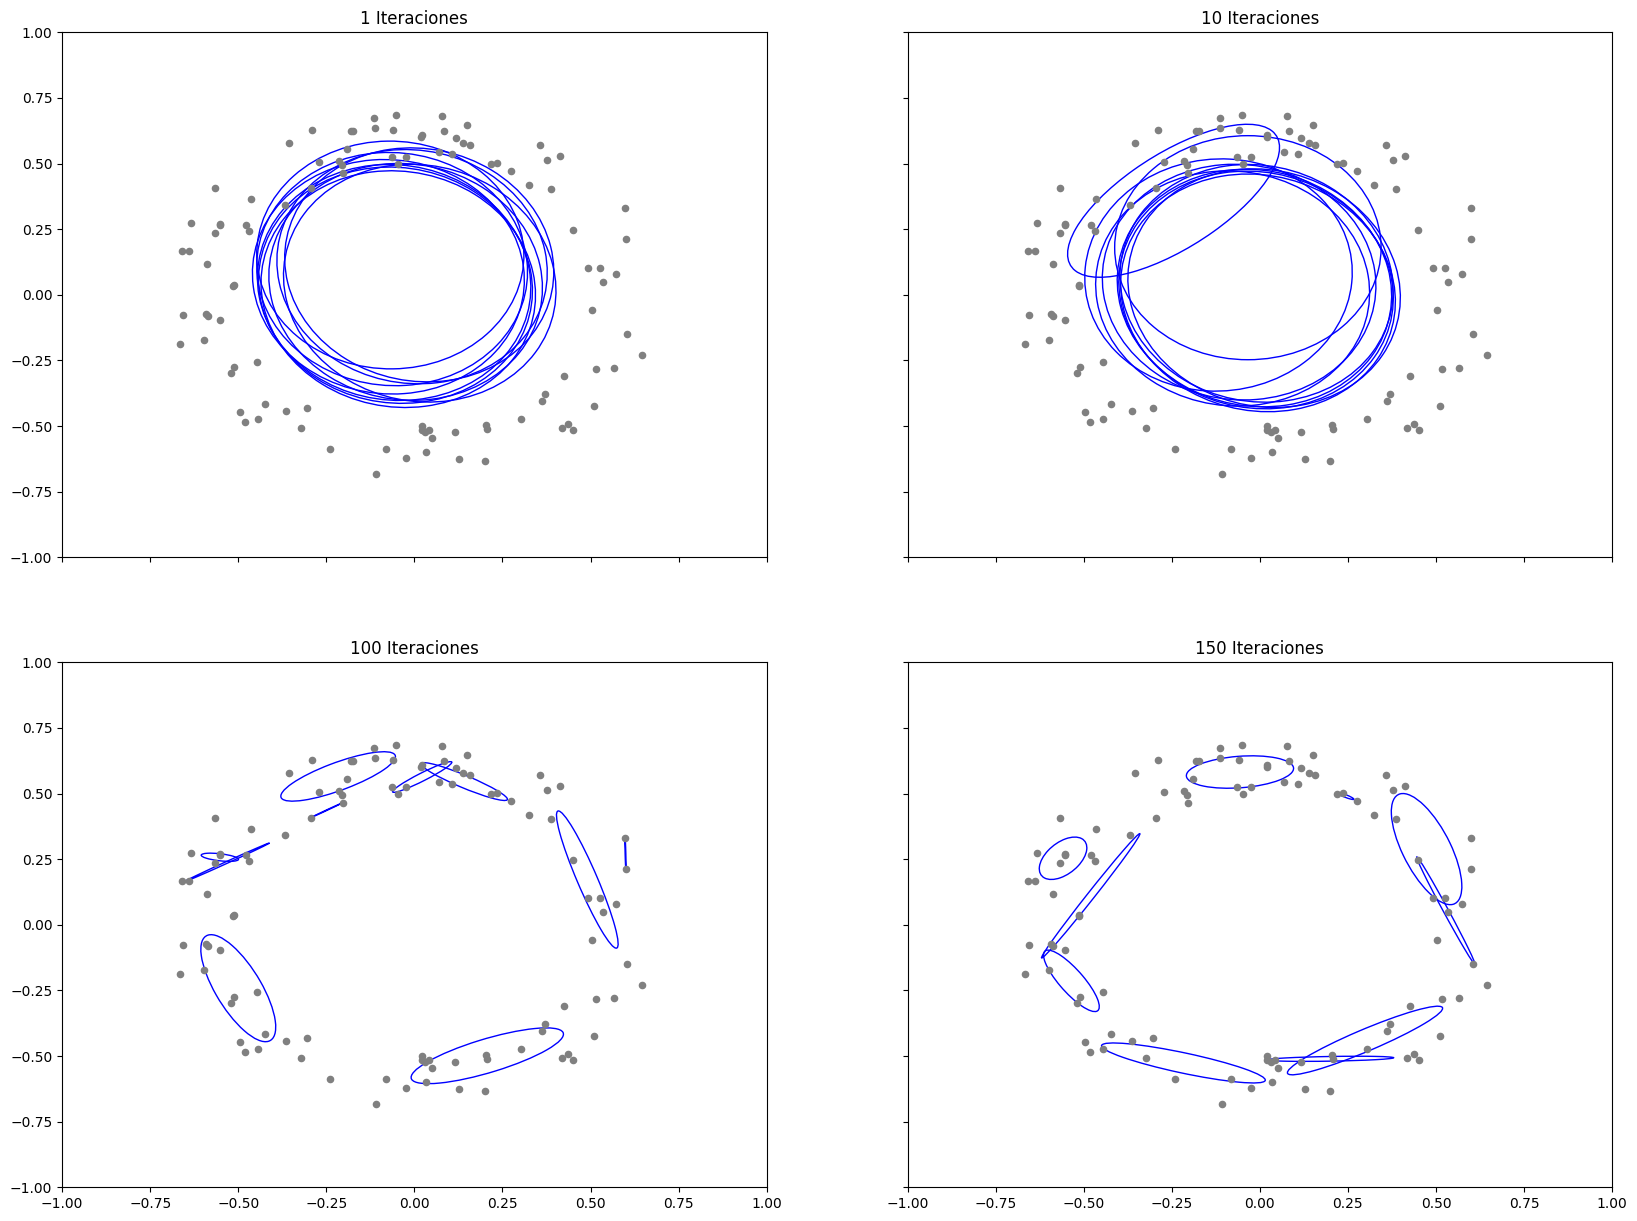

In [9]:
# Datos de ejemplo
l = 0.2
r1 = 0.5
rng = np.random.default_rng(123)
X = np.zeros((2, 100))
for r in range(100):
    rad = r1 + rng.uniform() * l
    theta = rng.uniform() * 2 * np.pi
    X[0, r] = rad * np.cos(theta)
    X[1, r] = rad * np.sin(theta)

# Parámetros del modelo
H = 10
opts = {'maxit': 150, 'meaninit': 0}

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharex=True, sharey=True)

# Ejecutar el algoritmo EM con diferentes iteraciones
for idx, it in enumerate([1, 10, 100, 150]):
    opts['maxit'] = it
    ph, mu, sigma, loglik, phgv = MIXGaussians(X, H, opts)

    for j in range(H):
        plot_gaussian_contour(mu[:, j], sigma[j], axes[idx // 2, idx % 2])

    axes[idx // 2, idx % 2].scatter(X[0], X[1], s=20, color='gray')
    axes[idx // 2, idx % 2].set_title(f'{it} Iteraciones')
    axes[idx // 2, idx % 2].set_xlim(-1, 1)
    axes[idx // 2, idx % 2].set_ylim(-1, 1)

plt.show()

In [ ]:
import numpy as np
from scipy.special import logsumexp

def MIXGaussians(v, H, opts):
    """
    MIXGaussians: algoritmo EM para entrenar una mezcla de gaussianas
    [ph, mu, sigma, loglik, phgv] = MIXGaussians(v, H, opts)

    Entrada:
    v : matriz de datos (cada columna es una muestra)
    H : número de componentes en la mezcla
    opts: diccionario con parámetros adicionales
          opts.maxit : número máximo de iteraciones
          opts.meaninit: si 1, inicializar las medias con los datos

    Salida:
    ph : p(h) (probabilidades a priori de los componentes)
    mu : medias de las gaussianas
    sigma : covarianzas de las gaussianas
    loglik : verosimilitud logarítmica del conjunto de datos
    phgv : p(h|v) asignación posterior de los datos a los componentes de la mezcla
    """

    D, N = v.shape  # Dimensión de los datos y número de muestras

    # Inicialización
    rng = np.random.default_rng()
    if opts['meaninit'] == 1:
        ph = np.ones(H) / H
        mu = v[:, :H]  # Inicializar medias usando los primeros H puntos
        sigma = np.array([np.cov(v) + 1e-6 * np.eye(D) for _ in range(H)])  # Evitar matrices singulares
    else:  # Inicialización aleatoria
        ph = rng.random(H)
        ph /= ph.sum()  # Garantizar que sea una distribución
        mu = rng.random((D, H)) * np.max(v, axis=1, keepdims=True)
        sigma = np.array([np.eye(D) for _ in range(H)])

    lik = np.zeros(opts['maxit'])  # Para guardar la verosimilitud en cada iteración
    phgv = np.zeros((H, N))  # Posterior p(h|v)

    for emloop in range(opts['maxit']):
        # Paso E
        log_phgv = np.zeros((H, N))
        for j in range(H):
            # Logaritmo de la densidad gaussiana multivariada
            # Implementa explícitamente el cálculo de la densidad gaussiana multivariada, usando:
                # La inversa de la matriz de covarianza.
                # El determinante de la matriz de covarianza.
                # La ecuación general para la distribución gaussiana multivariada.
            diff = v - mu[:, j:j+1]
            inv_sigma = np.linalg.inv(sigma[j])
            log_det_sigma = np.linalg.slogdet(sigma[j])[1]
            log_gauss = -0.5 * (np.sum(diff.T @ inv_sigma * diff.T, axis=1) + log_det_sigma + D * np.log(2 * np.pi))
            log_phgv[j, :] = np.log(ph[j]) + log_gauss

        # Normalizar
        log_phgv -= logsumexp(log_phgv, axis=0)
        phgv = np.exp(log_phgv)

        # Paso M
        htot = phgv.sum(axis=1)  # Números efectivos de cada componente
        ph = htot / N
        mu = (v @ phgv.T) / htot  # Medias ponderadas

        sigma = np.zeros((H, D, D))
        for j in range(H):
            diff = v - mu[:, j:j+1]
            sigma[j] = (phgv[j, :] * diff) @ diff.T / htot[j] + 1e-6 * np.eye(D)  # Regularización

        # Calcular la verosimilitud logarítmica
        loglik = np.sum(logsumexp(log_phgv, axis=0))
        lik[emloop] = loglik

    return ph, mu, sigma, lik, phgv